In [76]:
import gpxpy
import pandas as pd
import os
from datetime import datetime
import pytz
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import numpy as np

gpx_directory = '68551849/ride/'
local_tz = pytz.timezone('America/Los_Angeles')

In [77]:
data = []
for filename in os.listdir(gpx_directory):
    if filename.endswith('.gpx'):
        print(f"Parsing file....{filename}")
        FileID = filename
        gpx_file = open(os.path.join(gpx_directory, filename), 'r')
        gpx = gpxpy.parse(gpx_file)

        for track in gpx.tracks:
            for segment in track.segments:
                # Only take the first and last point of each segment
                start_point = segment.points[0]
                end_point = segment.points[-1]
                
                for point_type, point in zip(['Start', 'End'], [start_point, end_point]):
                    utc_time = datetime.utcfromtimestamp(point.time.timestamp())
                    local_time = utc_time.replace(tzinfo=pytz.utc).astimezone(local_tz)
                    #print(type(local_time))
                    day_of_week = local_time.isoweekday()
                    hour_of_day = local_time.hour
                    data.append([point.latitude, point.longitude, hour_of_day, day_of_week, point_type, FileID])

df = pd.DataFrame(data, columns=['Latitude', 'Longitude', 'HourOfDay','DayOfWeek', 'PointType','FileID'])

df['PointFeature'] = df['PointType'].apply(lambda x: -1 if x == 'Start' else 1)

Parsing file....8999076307.gpx
Parsing file....8932015947.gpx
Parsing file....9115934547.gpx
Parsing file....9046182374.gpx
Parsing file....8914248054.gpx
Parsing file....8997155702.gpx
Parsing file....8987516473.gpx
Parsing file....9084726470.gpx
Parsing file....8987607129.gpx
Parsing file....8993016108.gpx
Parsing file....9006525740.gpx
Parsing file....9003173105.gpx
Parsing file....8885774506.gpx
Parsing file....9128584773.gpx
Parsing file....8950086580.gpx
Parsing file....8967826254.gpx
Parsing file....8926392748.gpx
Parsing file....8919279228.gpx
Parsing file....9077350457.gpx
Parsing file....8991011278.gpx
Parsing file....8939029175.gpx
Parsing file....9075943483.gpx
Parsing file....8907088806.gpx
Parsing file....8890859129.gpx
Parsing file....9058117223.gpx
Parsing file....9091336682.gpx
Parsing file....9012483697.gpx
Parsing file....8957935093.gpx
Parsing file....9066438551.gpx
Parsing file....9012436563.gpx
Parsing file....8955805139.gpx
Parsing file....9035575071.gpx
Parsing 

In [78]:
df

,Latitude,Longitude,HourOfDay,DayOfWeek,PointType,FileID,PointFeature
0,33.647530,-117.839787,13,2,Start,8999076307.gpx,-1
1,33.668904,-117.827405,14,2,End,8999076307.gpx,1
2,33.644823,-117.841603,10,5,Start,8932015947.gpx,-1
3,33.668844,-117.827404,11,5,End,8932015947.gpx,1
4,33.669291,-117.827760,13,7,Start,9115934547.gpx,-1
...,...,...,...,...,...,...,...
127,33.644838,-117.841574,7,5,End,8889526045.gpx,1
128,33.668648,-117.827521,7,3,Start,8878209016.gpx,-1
129,33.644822,-117.841579,8,3,End,8878209016.gpx,1
130,33.644119,-117.840832,18,3,Start,8963885001.gpx,-1


In [79]:
# Run first DBSCAN
coords = df[['Latitude', 'Longitude']].values
coords_rad = np.radians(coords)

#Set Distance Threshold
kms_per_radian = 6371.0088
epsilon = 0.1 / kms_per_radian

# Run DBSCAN on lat, long
db = DBSCAN(eps=epsilon, min_samples=5, algorithm='ball_tree', metric='haversine').fit(coords_rad)
df['SpatialCluster'] = db.labels_
print(f"Found {len(df['SpatialCluster'].unique()) - 1} unique clusters")


Found 3 unique clusters


In [80]:
#Plotting Spatial Cluster Map

import folium

# Create map centered on mean coordinates
non_noise_df = df[df['SpatialCluster'] != -1]
map_center = [non_noise_df['Latitude'].mean(), non_noise_df['Longitude'].mean()]
print(map_center)
m = folium.Map(location=map_center, zoom_start=13)

# Use color palette to distinguish different clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
          'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
          'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
          'gray', 'black', 'lightgray']

# For each cluster, add a feature group to the map, add a circle for each point
for cluster_id in df['SpatialCluster'].unique():
    if cluster_id == -1:
        continue
    fg = folium.FeatureGroup(name=f'Spatial Cluster {cluster_id}')
    cluster_data = df[df['SpatialCluster'] == cluster_id]
    
    for idx, row in cluster_data.iterrows():
        folium.CircleMarker(location=[row['Latitude'], row['Longitude']],
                            radius=5,
                            fill=True,
                            color=colors[cluster_id % len(colors)],
                            fill_opacity=0.7).add_to(fg)
    fg.add_to(m)

folium.LayerControl().add_to(m)
#m.save('spatial_clusters_map.html')
m

[33.65927040909091, -117.83312039090907]


In [81]:
# Initialize a StandardScaler object
scaler = StandardScaler()

# Fit the scaler to the 'HourOfDay' column and transform the column
df['HourOfDay_scaled'] = scaler.fit_transform(df[['HourOfDay']])

# Step 2: Run DBSCAN within each spatial cluster using other features
df['Cluster'] = '-1'  # Initialize final cluster column

# We will create separate clusters for 'Start' and 'End' points
for point_type in ['Start', 'End']:
    subset_df = df[df['PointType'] == point_type]
    
    for spatial_cluster in subset_df['SpatialCluster'].unique():
        # Skip spatial cluster -1 (noise) for second round of clustering
        if spatial_cluster == -1:
            continue
        
        subset = subset_df[subset_df['SpatialCluster'] == spatial_cluster]
        if len(subset) >= 5:  # DBSCAN requires a minimum of 5 samples
            features = subset[['HourOfDay_scaled', 'PointFeature']].values
            dbscan = DBSCAN(eps=0.25, min_samples=5)  # Adjust these parameters
            clusters = dbscan.fit_predict(features)
            
            # We append point type to cluster number to distinguish between 'Start' and 'End'
            df.loc[(df['PointType'] == point_type) & (df['SpatialCluster'] == spatial_cluster), 'Cluster'] = [f'{spatial_cluster}_{c}_{point_type}' if c != -1 else "-1" for c in clusters]


In [82]:
df.Cluster.unique()

array(['-1', '1_0_End', '2_0_Start', '1_0_Start', '2_0_End', '1_1_Start',
       '0_0_End'], dtype=object)

In [83]:
import folium
import geopy.distance
from scipy.spatial.distance import cdist

non_noise_df = df[df['Cluster'] != '-1']
map_center = [non_noise_df['Latitude'].mean(), non_noise_df['Longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=13)

# Use color palette to distinguish different clusters
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
          'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue',
          'darkpurple', 'white', 'pink', 'lightblue', 'lightgreen',
          'gray', 'black', 'lightgray']

# For each cluster, add a feature group to the map, add a circle for each point
for cluster_id in df['Cluster'].unique():
    if cluster_id == '-1':
        continue
    fg = folium.FeatureGroup(name=f'Cluster {cluster_id}')
    cluster_data = df[df['Cluster'] == cluster_id]

    # Calculate 'center of mass' for this cluster
    cluster_points = cluster_data[['Latitude', 'Longitude']].values
    avg_dists = cdist(cluster_points, cluster_points).mean(axis=1)
    center_of_mass = cluster_points[avg_dists.argmin()]

    # Calculate median 'HourOfDay' for this cluster
    median_hour = cluster_data['HourOfDay'].median()

    # Define cluster color based on first part of cluster ID (splitting by underscore)
    cluster_color_id = int(cluster_id.split('_')[0]) if isinstance(cluster_id, str) else cluster_id
    cluster_color = colors[cluster_color_id % len(colors)]

    for idx, row in cluster_data.iterrows():
        folium.CircleMarker(location=[row['Latitude'], row['Longitude']],
                            radius=5,
                            fill=True,
                            color=cluster_color,
                            fill_opacity=0.7).add_to(fg)

    mean_location = [cluster_data['Latitude'].mean(), cluster_data['Longitude'].mean()]
    distances = cluster_data.apply(lambda row: geopy.distance.distance(mean_location, [row['Latitude'], row['Longitude']]).m, axis=1)
    percentile_distance = distances.quantile(0.7)

    # Draw a circle around the cluster
    folium.Circle(
        location=center_of_mass,
        radius=percentile_distance,
        color=cluster_color,
        fill=True,
        fill_opacity=0.2,
    ).add_to(fg)

    folium.Marker(
        location=center_of_mass,
        popup=f'Cluster ID: {cluster_id}<br>Lat: {mean_location[0]:.4f}<br>Lon: {mean_location[1]:.4f}<br>Hour of Day: {median_hour:.2f}',
        icon=folium.Icon(icon="map-marker", prefix='fa')  # Use a marker icon
    ).add_to(fg)
    
    fg.add_to(m)

folium.LayerControl().add_to(m)
#m.save('cluster_map.html')


In [84]:
m

In [85]:
df[df['Cluster'] == '2_0_Start']


,Latitude,Longitude,HourOfDay,DayOfWeek,PointType,FileID,PointFeature,SpatialCluster,HourOfDay_scaled,Cluster
2,33.644823,-117.841603,10,5,Start,8932015947.gpx,-1,2,-0.514071,2_0_Start
18,33.645414,-117.841260,12,1,Start,8993016108.gpx,-1,2,-0.046089,2_0_Start
28,33.645116,-117.841465,11,1,Start,8950086580.gpx,-1,2,-0.280080,2_0_Start
36,33.645115,-117.841553,11,1,Start,9077350457.gpx,-1,2,-0.280080,2_0_Start
46,33.644998,-117.841588,12,5,Start,8890859129.gpx,-1,2,-0.046089,2_0_Start
62,33.644774,-117.841593,12,1,Start,9035575071.gpx,-1,2,-0.046089,2_0_Start
90,33.645773,-117.841119,13,3,Start,9048255154.gpx,-1,2,0.187902,2_0_Start
98,33.644842,-117.841685,12,1,Start,9121402602.gpx,-1,2,-0.046089,2_0_Start
108,33.645243,-117.841426,11,1,Start,8908497091.gpx,-1,2,-0.280080,2_0_Start
114,33.645500,-117.841300,13,5,Start,9017210982.gpx,-1,2,0.187902,2_0_Start


In [ ]:
start_points = df[df['PointType'] == 'Start'].groupby('Cluster')['PointType'].count()
end_points = df[df['PointType'] == 'End'].groupby('Cluster')['PointType'].count()

# Calculate other statistics as before
cluster_details = df.groupby('Cluster').agg(
    MeanLatitude=('Latitude', 'mean'),
    MeanLongitude=('Longitude', 'mean'),
    MedianHourOfDay=('HourOfDay', 'median'),
    NumPoints=('Cluster', 'count')
)

# Add 'Start' and 'End' counts to the dataframe
cluster_details['StartPoints'] = start_points
cluster_details['EndPoints'] = end_points

print(cluster_details)


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from datetime import datetime
import gpxpy

In [62]:
def get_coordinates(gpx_file):
    gpx_file = open(gpx_file, 'r')
    gpx = gpxpy.parse(gpx_file)
    coordinates = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                coordinates.append((point.latitude, point.longitude))
    return coordinates

In [64]:
data = []
for file in df['FileID']:
    coordinates = get_coordinates(gpx_directory + file)
    data.extend(coordinates)

In [66]:
df_coordinates = pd.DataFrame(data, columns=['Latitude', 'Longitude'])


In [67]:
# Step 2 and 3: Generate and Aggregate Heatmaps
heatmap, xedges, yedges = np.histogram2d(df_coordinates['Latitude'], df_coordinates['Longitude'], bins=50)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

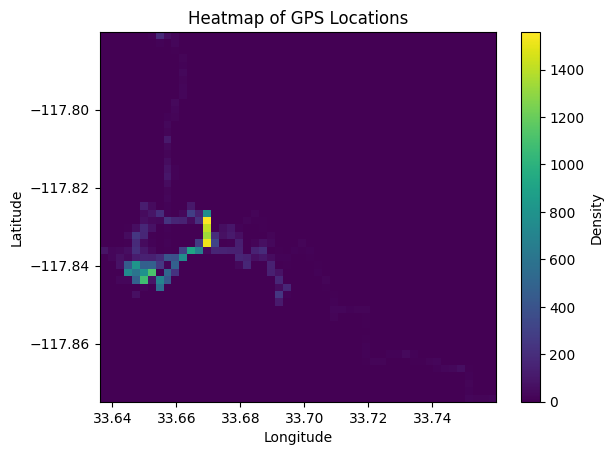

In [68]:
plt.imshow(heatmap.T, origin='lower', extent=extent, aspect='auto')
plt.colorbar(label='Density')
plt.title('Heatmap of GPS Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [69]:
# Step 4: Identify High-Density Regions
db = DBSCAN(eps=0.3, min_samples=10).fit(df_coordinates)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [72]:
# Step 5: Temporal Clustering - Here's a simplified version. You'll need to adapt it for your needs.
#df['Timestamp'] = pd.to_datetime(df['Timestamp'])  # Convert timestamp to datetime
#df['Hour'] = df['Timestamp'].apply(lambda x: x.hour)  # Extract hour
clusters = DBSCAN(eps=0.3, min_samples=10).fit(df[['HourOfDay']])  # Apply DBSCAN on hour
df['Cluster'] = clusters.labels_  # Add cluster labels to original DataFrame


In [88]:
df[df['Cluster'] == '2_0_Start']['FileID'].unique()

array(['8932015947.gpx', '8993016108.gpx', '8950086580.gpx',
       '9077350457.gpx', '8890859129.gpx', '9035575071.gpx',
       '9048255154.gpx', '9121402602.gpx', '8908497091.gpx',
       '9017210982.gpx'], dtype=object)